In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
# import plotly.express as pltly
# import plotly
import pandas as pd
# from functools import partial
import networkx as net
from utils import seq_scheduling
# import plotly.graph_objects as go

In [8]:
np.set_printoptions(suppress = True)

parameters for $\mu-L$ convergence
* $\mu = 2\lambda$       regularization parameter

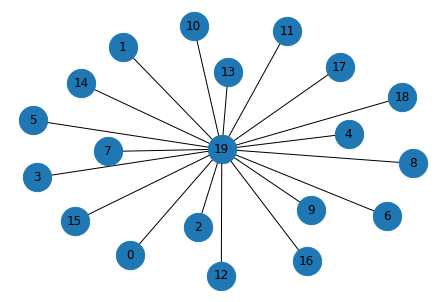

In [9]:
K = 20
# train_images=train_images.reshape((60000,784),order='C')
# SampleCov=[(train_images[sample_indices[i]].T @ train_images[sample_indices[i]]) / len(sample_indices[i]) for i in range(K)]
# lambdaSampleCov=[np.linalg.eigvalsh(SampleCov[i]).reshape((784,1)) for i in range(K)]
# E = 1./2*(np.eye(K) - np.ones((K,1)) @ np.ones((1,K)) / K)
# lambdaE=np.linalg.eigvalsh(E).reshape((K,1))
# lambda_base = [max(.5*lambdaSampleCov[i]).squeeze() for i in range(K)]
lamda = .002
# L = max(lambda_base) + lamda
L = .1581 + .002
mu = lamda
kappa = L / mu
# gb = .1 # as the norm bound G for gradient
bar_sigma_sqr= 1.
a0 = 20 # initial distance between the average model parameter and the optimal one


seeds = iter(range(1000))
prob = 0.5
alg_connect = 0
while alg_connect < 1e-4:
#     # Generate a star-based ER graph
#     ER = net.erdos_renyi_graph(K-1, 0.1, seed = next(seeds))
#     ER.add_node(K-1)
    G = net.star_graph(reversed(range(K)))
#     G.add_edges_from(ER.edges())

#     # Generate an arbitrary ER graph
#     G = net.erdos_renyi_graph(K, p, seed = next(seeds))

#     # Generate a chain (cycle) graph
#     G = net.cycle_graph(K)
#     G.remove_edge(0, K-1)
#     # Base an ER graph with prob on the chain graph to improve the spectral gap delta
#     ER = net.erdos_renyi_graph(K, prob, seed = next(seeds))
#     G.add_edges_from(ER.edges())

#     # Generate a 2-D torus (5-by-4)
#     G = net.grid_2d_graph(5, 4, periodic=True)
#     mapping = {(m,n):4*m+n for m, n in G.nodes()}
#     _ = net.relabel_nodes(G, mapping, copy=False)

#     # Generate a complete graph
#     G = net.complete_graph(K)

    LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
    E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
    alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
pos = net.spring_layout(G)
net.draw(G, pos, with_labels = True, node_size = 800, edge_size = 1000, font_size = 12)

delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)


# The optimum a' adpative to other paramters to minimize the upper-bound for optimality gap
# a_prime = ( (169 * 2 * gb**2 * delta) / (mu**2 * c**2 * rho**2 * (2-omega) * m**2/d * zeta_ini) ) ** (1/3)
# when p(t) >= p_ini for the whole training iterations
# a_prime = ( (169 * 2 * gb**2 * 4 * p_ini) / (mu**2 * c**2 * rho**2 * (2-omega) * m**2/d * zeta_ini**2) ) ** (1/3)

In [10]:
# Set distances among any pair of nodes
d_min = 50
d_max = 200
rho =  d_min + (d_max - d_min) * np.random.rand(K,1) 
theta = 2 * np.pi * np.random.rand(K,1)
# D = np.ones((K, K))
D = np.sqrt(rho ** 2 + rho.T ** 2 - 2 * (rho @ rho.T) * np.cos(theta - theta.T))
# Fill in D[i,i] some non-zero value to avoid Inf in PL
for i in range(K):
    if i:
        D[i,i] = D[i,i-1]
    else:
        D[i,i] = D[i,i+1]
A0 = 10 ** (-3.35)
d0 = 1
gamma = 3.76
PL = A0 * ((D / d0) ** (-gamma)) 

In [11]:
barP = 2e-8
N_0 = 10 ** (-169/10) * 1e-3
M = 10
# rSNR_list = [barP/N_0 * M * A0 * min( (D[i,j] /d0) ** -gamma for j in G[i] ) for i in range(K)]
10 * np.log10(barP/N_0 * M * A0 * ( 125 /d0) ** -gamma)

19.66648346753688

Theorem 0 (No Commun.)
$$\mathbb{E}[f(x^{(T)}_{avg})-f(x^\ast)]\le\frac{\mu}{3.25}\frac{a^3-3.25a^2}{S_T}v_e^{(0)} + \frac{1.625T(T+2a)}{\mu S_T}\frac{{\bar\sigma}^2}{K}+1.5L\left(1+\frac{1}{K}\right)^2\frac{4}{\mu^2}G^2$$

Theorem 1 
$$\mathbb{E}[f(x^{(T)}_{avg})-f(x^\ast)]\le\frac{\mu}{3.25}\frac{a^3-3.25a^2}{S_T}v_e^{(0)} + \frac{1.625T(T+2a)}{\mu S_T}\frac{{\bar\sigma}^2}{K}+\frac{158.45\times 24LT}{\mu^2(p(\delta,\omega))^2S_T}G^2$$

Theorem 2 (modification of Theorem 19 [A.Koloskova *et al.* 19])
$$\mathbb{E}[f(x^{(T)}_{avg})-f(x^\ast)]\le\frac{\mu}{3.25}\frac{a^3-3.25a^2}{S_T}v_e^{(0)}+\frac{1.625T(T+2a)}{\mu S_T}\frac{\bar\sigma^2}{K}+\frac{158.45\left(24G^2+\frac{A(\delta,\omega)}{K}\sqrt[\leftroot{-2}\uproot{4}4]{\tilde N_{0,T}}\right)LT}{\mu^2(p^{(T)}(\delta,\omega))^2 S_T}+C(\delta,\omega,\tilde N_{0,T})$$
in which $p^{(t)}(\delta,\omega)=\min\{\tilde p^{(t)}(\delta,\omega), p(\delta,\omega)\}$ with  
$$\tilde p^{(t)}(\delta,\omega)=\frac{\delta\zeta_0}{\sqrt[\leftroot{-2}\uproot{4}4]{\tilde N_{0,T}}t/a^\prime+1}-\left(\frac{\delta^2}{4}+\frac{2}{\omega}\beta^2\right)\frac{\zeta_0^2}{\big(\sqrt[\leftroot{-2}\uproot{4}4]{\tilde N_{0,T}}t/a^\prime+1\big)^2}, $$ and 
$$C(\delta,\omega,\tilde N_{0,T})=\frac{1}{K^2}(\zeta_0(\delta,\omega)a^\prime)^2\omega^2d\frac{\mu}{3.25}\sqrt{\tilde N_{0,T}}$$
$$A(\delta,\omega)=\delta(\zeta_0(\delta,\omega)a^\prime)^3(2-\omega)\omega^2d\left(\frac{\mu}{3.25}\right)^2$$

Use the historical noise data to estimate $\sqrt[4]{\tilde N_{0,T}}$, where $\tilde N_{0,T}=\max\limits_{t\in\{0,\ldots,T-1\}}\{\sum_{i\in\mathcal{V}}\tilde N_{0i}^{(t)}\}$ with 
$$\tilde N_{0i}^{(t)} = \frac{N_0}{2}\left(\sum\limits_{s\in\mathcal{S}_j^{\rm AR}}\frac{1}{\gamma_j^{(t,s)}}+\sum\limits_{s\in\mathcal{S}_j^{\rm BR}}\frac{w_{ji_s}^2}{\alpha_{i_s}^{(t,s)}\left|h_{i_sj}^{\prime(t)}\right|^2}\right)$$

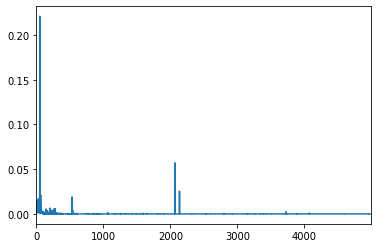

In [13]:
with open('./data/simulations/noise_e_SCHEME_6_P_0.0002mW_N_7943_a_200.00_zeta0_0.0500_a_prime_1000.00.pkl', 'rb') as noiseses:
    noiseses = pickle.load(noiseses)
# noise_errors is of shape (training_times, ComRound, K), where training_times=1 herein
df = pd.DataFrame(np.squeeze(np.array(noiseses)), columns = ['Device_{}'.format(i + 1) for i in range(K)] )
df.mean(axis = 1).plot(color = 'tab:blue', label = r'$\sum_{i\in\mathcal{V}}\tilde N_{0i}^{(t)}$')
tilde_N0_T = np.max( df.mean(axis = 1) )

In [14]:
df.mean(axis = 1).mean()

0.00016511892608441644

**Evaluate the analytical upper-bound (*relative*) for $F({\bar{\theta}}^{(t)}) - F^\ast$ with varying $\rho$**

Some useful $\lambda$ expressions

In [15]:
p = lambda delta, beta, omega: delta**2 * omega / (2 * (16*delta + delta**2 + 4*beta**2 + 2*delta*beta**2 - 8*delta*omega))
zeta0 = lambda delta, beta, omega: delta * omega / (16*delta + delta**2 + 4*beta**2 + 2*delta*beta**2 - 8*delta*omega)

tilde_p_t= lambda t, delta, beta, omega, tilde_N0:  -(delta**2 /4 + 2*beta**2 /omega) * (zeta0(delta,beta,omega))**2 / ( (tilde_N0)**(.25)*t/a_prime+1 )**2 + delta*zeta0(delta,beta,omega)/( (tilde_N0)**(.25)*t/a_prime+1 )
p_t = lambda t, delta, beta, omega, tilde_N0: np.minimum(tilde_p_t(t, delta, beta, omega, tilde_N0), p(delta, beta, omega))

C = lambda delta, beta, omega, tilde_N0: 1/K**2 * ( zeta0(delta, beta, omega)*a_prime*omega )**2 *d*mu/3.25*(tilde_N0)**0.5
A = lambda delta, beta, omega: delta * ( zeta0(delta, beta, omega)*a_prime )**3 * (2-omega)*omega**2*d*((mu/3.25)**2)

In [112]:
d = 7850
# a = 1.4e6
# tilde_N0_T_org = 0.000021 # assuming tilde N_{0,T} is calculated based on barP = 2e-7
# a_prime = 1e5 # a_prime> a * (\tilde N_{0,T})**(.25), 
# M = 10 # the number of scheduling slots for the analog scheme
N = 30000
Tmax = 5e3
# opt = 0.41
# Generate a 2-D torus (5-by-4)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)

schedule_list, Tx_times = seq_scheduling(G.copy())
m = int(N / (2 * len(schedule_list) ))
omega = m / d

In [113]:
gb = 1 # as the norm bound G for gradient
tilde_N0_T_org = 0.000001 # assuming tilde N_{0,T} is calculated based on barP = 2e-7
barP = 2e-7
tilde_N0_T= tilde_N0_T_org * (2e-7/barP)
a = 3e6
a_prime = a * tilde_N0_T**(.25)
print(f'{a} | {max(5/p_t(Tmax,delta,beta,omega,tilde_N0_T), 13*L/mu)}')
print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 

3000000.0 | 4797.84934048638
94868.32980505137 | 94868.32980505137


3000000.0 | 4797.84934048638
94868.32980505137 | 53348.38230116769
3000000.0 | 4797.84934048638
54000.0 | 168702.3975571047


C:\Users\Helen\.conda\envs\dsgd\lib\site-packages\ipykernel_launcher.py:76: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


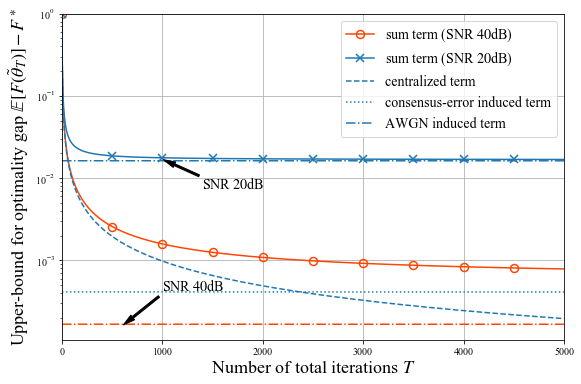

In [114]:
# Tmax = 5e3
T_array = np.arange(1,Tmax)
sT = np.cumsum((a+T_array)**2)
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))

# # ideal communication with the estimation quality omega = 1
# omega = 1
# og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og, ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'ideal commun.')


# omega = m / d # Once the topology of the connectivity graph is given, m and thus \omega are fixed

# barP = 2e-3
# tilde_N0_T= tilde_N0_T_org * (2e-7/barP)
# og1 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * ( 24 * gb**2 + A(delta,beta,omega)/K * (tilde_N0_T)**(.25) ) * L * T_array) / (mu**2 * ( p_t(T_array, delta, beta, omega, tilde_N0_T) ) **2 * sT) \
# + C(delta, beta, omega, tilde_N0_T)
# plt.semilogy(T_array, og1, color = 'orangered', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'average SNR $42$dB')


barP = 2e-6
tilde_N0_T= tilde_N0_T_org * (2e-7/barP)
print(f'{a} | {max(5/p_t(Tmax,delta,beta,omega,tilde_N0_T), 13*L/mu)}')
print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 
a_prime = 5.4e4
og1 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * ( 24 * gb**2 + A(delta,beta,omega)/K * (tilde_N0_T)**(.25) ) * L * T_array) / (mu**2 * ( p_t(T_array, delta, beta, omega, tilde_N0_T) ) **2 * sT) \
+ C(delta, beta, omega, tilde_N0_T)
plt.semilogy(T_array, og1/og1[0], color = 'orangered', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'sum term (SNR $40$dB)')

# og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K)
# plt.semilogy(T_array, og1_partI/og1[0], ls = '--', color = 'orangered', label = r'centralized term')

# og1_partII = (158.45 * ( 24 * gb**2 ) * L * T_array) / (mu**2 * ( p_t(T_array, delta, beta, omega, tilde_N0_T) ) **2 * sT)
# plt.semilogy(T_array, og1_partII/og1[0], ls = ':', color = 'orangered', label = r'consensus-error induced term')

og1_partIII = (158.45 * A(delta,beta,omega) / K * (tilde_N0_T)**(.25) * L * T_array) / (mu**2 * ( p_t(T_array, delta, beta, omega, tilde_N0_T) ) **2 * sT) + \
+ C(delta, beta, omega, tilde_N0_T)
plt.semilogy(T_array, og1_partIII/og1[0], ls = '-.', color = 'orangered')


barP = 2e-8
tilde_N0_T= tilde_N0_T_org * (2e-7/barP)
print(f'{a} | {max(5/p_t(Tmax,delta,beta,omega,tilde_N0_T), 13*L/mu)}')
print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 
a_prime = 1.7e5
og2 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * ( 24 * gb**2 + A(delta,beta,omega)/K * (tilde_N0_T)**(.25) ) * L * T_array) / (mu**2 * ( p_t(T_array, delta, beta, omega, tilde_N0_T) ) **2 * sT) \
+ C(delta, beta, omega, tilde_N0_T)
plt.semilogy(T_array, og2/og2[0], color = 'C0', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'sum term (SNR $20$dB)')

og2_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K)
plt.semilogy(T_array, og2_partI/og2[0], ls = '--', color = 'C0', label = r'centralized term')

og2_partII = (158.45 * ( 24 * gb**2 ) * L * T_array) / (mu**2 * ( p_t(T_array, delta, beta, omega, tilde_N0_T) ) **2 * sT)
plt.semilogy(T_array, og2_partII/og2[0], ls = ':', color = 'C0', label = r'consensus-error induced term')

og2_partIII = (158.45 * A(delta,beta,omega) / K * (tilde_N0_T)**(.25) * L * T_array) / (mu**2 * ( p_t(T_array, delta, beta, omega, tilde_N0_T) ) **2 * sT) + \
+ C(delta, beta, omega, tilde_N0_T)
plt.semilogy(T_array, og2_partIII/og2[0], ls = '-.', color = 'C0', label = r'AWGN induced term')

plt.xlabel(r'Number of total iterations $T$', fontsize = 18)
plt.ylabel(r'Upper-bound for optimality gap $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
plt.xlim((0, 5000))
plt.ylim((0, 1))
plt.grid()

# Place legend for individual curves
plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'SNR $20$dB',
            xy = (1000, 0.017), xycoords = 'data',
            xytext = (40, -30), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'SNR $40$dB',
            xy = (600, 0.00016), xycoords = 'data',
            xytext = (40, 35), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
# _ = ax.annotate(r'SNR $20$dB',
#             xy = (400, 0.019), xycoords = 'data',
#             xytext = (40, 30), textcoords = 'offset points', fontsize = 14,
#             arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
# _ = ax.annotate(r'SNR $40$dB',
#             xy = (3000, 0.001), xycoords = 'data',
#             xytext = (40, 35), textcoords = 'offset points', fontsize = 14,
#             arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

#plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/ana_ub_og_vs_SNR.eps',format='eps', dpi=600)
plt.show()

In [54]:
(og2_partI[4998]+og2_partII[4998]+og2_partIII[4998])

372.32111921156275

In [90]:
(og2/og2[0]).min()

0.016877639372659983

**Evaluate the analytical upper-bound (*relative*) for $F({\bar{\theta}}^{(t)}) - F^\ast$ with varying topologies**

In [91]:
d = 7850
# a = 1.4e6
# tilde_N0_T_org = 0.000021 # assuming tilde N_{0,T} is calculated based on barP = 2e-7
# a_prime = 1e5 # a_prime> a * (\tilde N_{0,T})**(.25), 
# M = 10 # the number of scheduling slots for the analog scheme
N = 30000
Tmax = 5e3
# opt = 0.41
# Generate a 2-D torus (5-by-4)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)

schedule_list, Tx_times = seq_scheduling(G.copy())
m = int(N / (2 * len(schedule_list) ))
omega = m / d

In [103]:
gb = 1 # as the norm bound G for gradient
tilde_N0_T_org = 0.000001 # assuming tilde N_{0,T} is calculated based on barP = 2e-7
barP = 2e-7
tilde_N0_T= tilde_N0_T_org * (2e-7/barP)
a = 2e6
a_prime = a * tilde_N0_T**(.25)
print(f'{a} | {max(5/p_t(Tmax,delta,beta,omega,tilde_N0_T), 13*L/mu)}')
print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 

2000000.0 | 4797.84934048638
63245.553203367585 | 63245.553203367585


3000000.0 | 4797.84934048638
64000.0 | 94868.32980505137
3000000.0 | 2208.3396704689503
64000.0 | 94868.32980505137


C:\Users\Helen\.conda\envs\dsgd\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


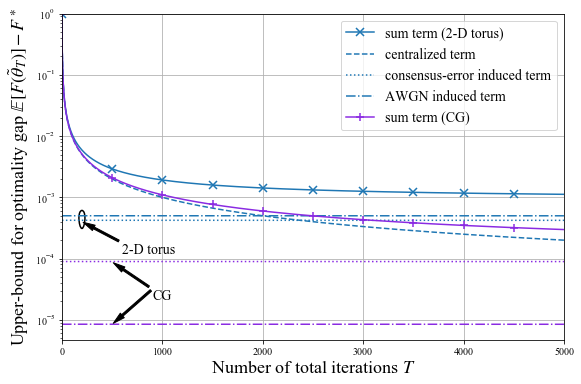

In [164]:
T_array = np.arange(1,Tmax)
sT = np.cumsum((a+T_array)**2)
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))


barP = 2e-7
tilde_N0_T= tilde_N0_T_org * (2e-7/barP)
print(f'{a} | {max(5/p_t(Tmax,delta,beta,omega,tilde_N0_T), 13*L/mu)}')
print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 
a_prime = 6.4e4
og1 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * ( 24 * gb**2 + A(delta,beta,omega)/K * (tilde_N0_T)**(.25) ) * L * T_array) / (mu**2 * ( p_t(T_array, delta, beta, omega, tilde_N0_T) ) **2 * sT) \
+ C(delta, beta, omega, tilde_N0_T)
plt.semilogy(T_array, og1/og1[0], color = 'C0', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'sum term (2-D torus)')

og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K)
plt.semilogy(T_array, og1_partI/og1[0], ls = '--', color = 'C0', label = r'centralized term')

og1_partII = (158.45 * ( 24 * gb**2 ) * L * T_array) / (mu**2 * ( p_t(T_array, delta, beta, omega, tilde_N0_T) ) **2 * sT)
plt.semilogy(T_array, og1_partII/og1[0], ls = ':', color = 'C0', label = r'consensus-error induced term')

og1_partIII = (158.45 * A(delta,beta,omega) / K * (tilde_N0_T)**(.25) * L * T_array) / (mu**2 * ( p_t(T_array, delta, beta, omega, tilde_N0_T) ) **2 * sT) + \
+ C(delta, beta, omega, tilde_N0_T)
plt.semilogy(T_array, og1_partIII/og1[0], ls = '-.', color = 'C0', label = r'AWGN induced term')


# Generate a complete graph
G = net.complete_graph(K)
# # Generate a star graph
# G = net.star_graph(range(K))
# # Generate a chain (cycle) graph
# G = net.cycle_graph(K)
# G.remove_edge(0, K-1)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta2 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta2 = np.linalg.norm(np.eye(K) - W, ord=2)

schedule_list, Tx_times = seq_scheduling(G.copy())
m = int(N / (2 * len(schedule_list) ))
omega2 = m / d
print(f'{a} | {max(5/p_t(Tmax,delta2,beta2,omega2,tilde_N0_T), 13*L/mu)}')
print(f'{a_prime} | {a * tilde_N0_T**(.25)}') 
a_prime = 6.4e4
og2 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * (24 * gb**2 + A(delta2,beta2,omega2)/K * (tilde_N0_T)**(.25)) * L * T_array) / (mu**2 * ( p_t(T_array, delta2, beta2, omega2, tilde_N0_T) ) **2 * sT) \
+ C(delta2, beta2, omega2, tilde_N0_T)
plt.semilogy(T_array, og2/og2[0], color = 'blueviolet', marker = '+', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'sum term (CG)')

# og2_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K)
# plt.semilogy(T_array, og2_partI/og2[0], ls = '--', color = 'blueviolet')

og2_partII = (158.45 * ( 24 * gb**2 ) * L * T_array) / (mu**2 * ( p_t(T_array, delta2, beta2, omega2, tilde_N0_T) ) **2 * sT)
plt.semilogy(T_array, og2_partII/og2[0], ls = ':', color = 'blueviolet')

og2_partIII = (158.45 * A(delta2,beta2,omega2) / K * (tilde_N0_T)**(.25) * L * T_array) / (mu**2 * ( p_t(T_array, delta2, beta2, omega2, tilde_N0_T) ) **2 * sT) + \
+ C(delta2, beta2, omega2, tilde_N0_T)
plt.semilogy(T_array, og2_partIII/og2[0], ls = '-.', color = 'blueviolet')


# # no communication with bounded consensus error derived as a result of (expected) norm bound for gradients
# ogLocal = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) +\
# 1.5 * L * (1 + 1./K)**2 * (4 / mu**2) * gb**2
# plt.semilogy(T_array, ogLocal, color = 'tab:green')


plt.xlabel(r'Number of total iterations $T$', fontsize = 18)
plt.ylabel(r'Upper-bound for optimality gap $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
plt.xlim((0, 5000))
plt.ylim((0, 1))
plt.grid()

# Place legend for individual curves
plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
# from matplotlib.patches import Ellipse
el = Ellipse((200, 4.6e-4), 60, 3e-4, angle = 0, fill = False, lw = 1.5)
ax.add_artist(el)
_ = ax.annotate(r'CG',
            xy = (500, 8.8e-5), xycoords = 'data',
            xytext = (40, -38), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'',
            xy = (500, 8.4e-6), xycoords = 'data',
            xytext = (40, 35), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'2-D torus',
            xy = (200, 4e-4), xycoords = 'data',
            xytext = (40, -32), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
# _ = ax.annotate(r'average SNR $42$dB',
#             xy = (3500, 27), xycoords = 'data',
#             xytext = (30, 15), textcoords = 'offset points', fontsize = 14,
#             arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
# _ = ax.annotate(r'average SNR $72$dB',
#             xy = (3000, 16), xycoords = 'data',
#             xytext = (40, -35), textcoords = 'offset points', fontsize = 14,
#             arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
# _ = ax.annotate(r'ideal commun.',
#             xy = (1500, 12.4), xycoords = 'data',
#             xytext = (-120, -30), textcoords = 'offset points', fontsize = 14,
#             arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/ana_ub_og_vs_topology.eps',format='eps', dpi=600)
plt.show()

In [464]:
og2.min()/og2[0]

0.002592039286315528

In [159]:
og1_partII[500]/og1[0]

0.0004212845375525469

In [399]:
og2_partIII

array([51.52664831, 51.5266279 , 51.5266075 , ..., 51.42485225,
       51.42483191, 51.42481156])

In [129]:
og2

array([33948.23281265, 33639.90002185, 33536.6780184 , ...,
       30213.60446078, 30213.0202508 , 30212.43605612])

In [109]:
len(schedule_list)

19

In [123]:
fig.get_linewidth()

AttributeError: 'Figure' object has no attribute 'get_linewidth'

**Evaluate the emprical optimality gap of $F({\bar{\theta}}^{(t)}) - F^\ast$ with varying $\rho$**

In [747]:
opt = 0.41
losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_1_a_1000.00_zeta0_0.1000_torus_n-9.pkl', 'rb') )
losseses = np.array(losseses[9]) - opt
K = losseses.shape[1]
df1 = pd.DataFrame(losseses, columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_4_P_2.0000mW_N_7943_a_1000.00_zeta0_0.1000_a_prime_200.00_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
df2 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_4_P_0.002000mW_N_7943_a_1000.00_zeta0_0.1000_a_prime_36.00_torus_n-1.pkl', 'rb') )
losseses = np.array(losseses[1]) - opt
df3 = pd.DataFrame(losseses, columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_4_P_0.000020mW_N_7943_a_1000.00_zeta0_0.1000_a_prime_11.00_torus_n-1.pkl', 'rb') )
losseses = np.array(losseses[1]) - opt
df4 = pd.DataFrame(losseses, columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_4_P_0.000002mW_N_7943_a_1000.00_zeta0_0.1000_a_prime_6.00_torus_n-9.pkl', 'rb') )
losseses = np.array(losseses[9]) - opt
df5 = pd.DataFrame(losseses, columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('./data/simulations/losseses_SCHEME_2_P_0.000002mW_N_7943_a_200.00_zeta0_0.0005_a_prime_200.00_2-D_torus.pkl', 'rb') )
# losseses = np.array(losseses) - opt
# df6 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('./data/losseses_SCHEME_1_eta0_2.00_zeta0_1.00_10-0.pkl', 'rb') )
# losseses = np.array(losseses) - opt
# df7 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_local_a_1000.00.pkl', 'rb') )
losseses = np.array(losseses[1]) - opt
df8 = pd.DataFrame(losseses, columns = ['Device_{}'.format(i + 1) for i in range(K)] )

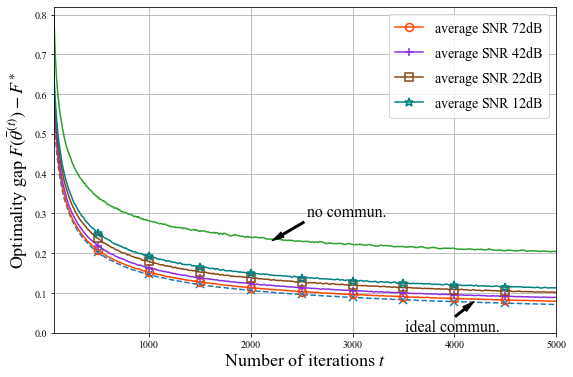

In [757]:
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))
# "mew" stands for markedgewidth, which is supposed to be set equal to the width of the line
df1.rolling(window = 20).mean().mean(axis = 1).plot(style = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label='')
df2.rolling(window = 29).mean().mean(axis = 1).plot(color = 'orangered', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'average SNR $72$dB')
df3.rolling(window = 29).mean().mean(axis = 1).plot(color = 'blueviolet', marker = '+', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'average SNR $42$dB')
df4.rolling(window = 29).mean().mean(axis = 1).plot(color = 'saddlebrown', marker = 's', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'average SNR $22$dB')
df5.rolling(window = 29).mean().mean(axis = 1).plot(color = 'teal', marker = '*', fillstyle = 'none', ms = 9, mew = 1.5, markevery = 500, label = r'average SNR $12$dB')
# df6.rolling(window = 30).mean().mean(axis = 1).plot(color = 'tab:blue', label = r'average SNR $8$dB')
# df7.rolling(window = 10).mean().mean(axis = 1).plot(style = '--', color = 'blueviolet', label = 'Ideal commun.')
df8.rolling(window = 49).mean().mean(axis = 1).plot(color = 'tab:green', label = '')

plt.xlabel(r'Number of iterations $t$', fontsize = 18)
plt.ylabel(r'Optimality gap $F(\bar{\theta}^{(t)})-F^\ast$', fontsize = 18)
# plt.title(r'ER graph with $p = 0.2$ and $\barP = -57$dBm', fontsize = 14)
plt.xlim((70, 5000))
plt.ylim((0, 0.82))
plt.grid()

# Place legend for individual curves
plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'ideal commun.',
            xy = (4200, .08), xycoords = 'data',
            xytext = (-70, -30), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'no commun.',
            xy = (2200, .23), xycoords = 'data',
            xytext = (36, 25), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# _ = plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/ana_og_vs_SNR.eps',format='eps', dpi=600)
plt.show()

In [752]:
df8.rolling(window = 49).mean().mean(axis = 1)[2200]

0.2360439474911126

In [761]:
p = lambda delta, beta, omega: delta**2 * omega / (2 * (16*delta + delta**2 + 4*beta**2 + 2*delta*beta**2 - 8*delta*omega))
zeta0 = lambda delta, beta, omega: delta * omega / (16*delta + delta**2 + 4*beta**2 + 2*delta*beta**2 - 8*delta*omega)

tilde_p_t= lambda t, delta, beta, omega, tilde_N0:  -(delta**2 /4 + 2*beta**2 /omega) * (zeta0(delta,beta,omega))**2 / ( (tilde_N0)**(.25)*t/a_prime+1 )**2 + delta*zeta0(delta,beta,omega)/( (tilde_N0)**(.25)*t/a_prime+1 )
p_t = lambda t, delta, beta, omega, tilde_N0: np.minimum(tilde_p_t(t, delta, beta, omega, tilde_N0), p(delta, beta, omega))

C = lambda delta, beta, omega, tilde_N0: 1/K**2 * ( zeta0(delta, beta, omega)*a_prime*omega )**2 *d*mu/3.25*(tilde_N0)**0.5
A = lambda delta, beta, omega: delta * ( zeta0(delta, beta, omega)*a_prime )**3 * (2-omega)*omega**2*d*((mu/3.25)**2)

**Evaluate the analytical upper-bound for $F({\bar{\theta}}^{(t)}) - F^\ast$ under varying topologies**

In [1898]:
K = 20
d = 7850
a = 1.6e6
gb = 2
tilde_N0_T_org = 0.000000021 # assuming tilde N_{0,T} is calculated based on barP = 2e-7
a_prime = 2e4 # a_prime> a * (\tilde N_{0,T})**(.25), 

In [1923]:
a_prime / ((tilde_N0_T_org)**(.25))

1661403.6948825584

C:\Users\Helen\.conda\envs\dsgd\lib\site-packages\ipykernel_launcher.py:119: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


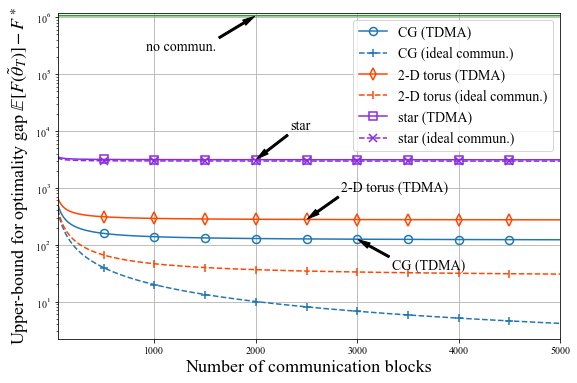

In [1922]:
N = 10000
m = int(N / K) # assuming the scheduling policy of TDMA for fair comparison among varying topologies
omega = m / d # Once the topology of the connectivity graph is given, m and thus \omega are fixed

Tmax = 5e3
T_array = np.arange(1,Tmax)
sT = np.cumsum((a+T_array)**2)
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))


# Generate a complete graph
G = net.complete_graph(K)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP

delta1 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta1 = np.linalg.norm(np.eye(K) - W, ord=2)
og1 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * (24 * gb**2 + A(delta1,beta1,omega)/K * (tilde_N0_T)**(.25)) * L * T_array) / (mu**2 * ( p_t(T_array, delta1, beta1, omega, tilde_N0_T) ) **2 * sT) \
+ C(delta1, beta1, omega, tilde_N0_T)
plt.semilogy(T_array, og1, marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'CG (TDMA)')
# ideal communication with the estimation quality omega = 1
omega = 1
og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta1,beta1,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og, color = 'C0', ls = '--', marker = '+', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'CG (ideal commun.)')


# Generate a 2-D torus (5-by-4)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP

delta2 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta2 = np.linalg.norm(np.eye(K) - W, ord=2)
og2 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * (24 * gb**2 + A(delta2,beta2,omega)/K * (tilde_N0_T)**(.25)) * L * T_array) / (mu**2 * ( p_t(T_array, delta2, beta2, omega, tilde_N0_T) ) **2 * sT) \
+ C(delta2, beta2, omega, tilde_N0_T)
plt.semilogy(T_array, og2, color = 'orangered', marker = 'd', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'2-D torus (TDMA)')
# ideal communication with the estimation quality omega = 1
omega = 1
og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta2,beta2,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og, color = 'orangered', ls = '--', marker = '|', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'2-D torus (ideal commun.)')


# Generate a star graph
G = net.star_graph(reversed(range(K)))
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP

delta3 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta3 = np.linalg.norm(np.eye(K) - W, ord=2)
og3 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * (24 * gb**2 + A(delta3,beta3,omega)/K * (tilde_N0_T)**(.25)) * L * T_array) / (mu**2 * ( p_t(T_array, delta3, beta3, omega, tilde_N0_T) ) **2 * sT) \
+ C(delta3, beta3, omega, tilde_N0_T)
plt.semilogy(T_array, og3, color = 'blueviolet', marker = 's', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'star (TDMA)')
# ideal communication with the estimation quality omega = 1
omega = 1
og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta3,beta3,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og,  color = 'blueviolet', ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'star (ideal commun.)')


# # Generate a chain (cycle) graph
# G = net.cycle_graph(K)
# G.remove_edge(0, K-1)
# LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
# E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
# alg_connect = E[1] 
# alpha = 2 / (E[K-1] + E[1])
# W = np.eye(K) - alpha * LP

# delta4 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
# beta4 = np.linalg.norm(np.eye(K) - W, ord=2)
# p4 = p(delta4,beta4,omega)
# og4 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * (24 * gb**2 + A(delta4,beta4,omega)/K * (tilde_N0_T)**(.25)) * L * T_array) / (mu**2 * ( p_t(T_array, delta4, beta4, omega, tilde_N0_T) ) **2 * sT) \
# + C(delta4, beta4, omega, tilde_N0_T)
# plt.semilogy(T_array, og4, color = 'saddlebrown', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'chain (TDMA)')
# # ideal communication with the estimation quality omega = 1
# omega = 1
# og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T_array) / (mu**2 * p(delta4,beta4,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og, color = 'saddlebrown', ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'chain (ideal commun.)')


# no communication with bounded consensus error derived as a result of (expected) norm bound for gradients
ogLocal = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) +\
1.5 * L * (1 + 1./K)**2 * (4 / mu**2) * gb**2
plt.semilogy(T_array, ogLocal, color = 'tab:green')

plt.xlabel(r'Number of communication blocks', fontsize = 18)
plt.ylabel(r'Upper-bound for optimality gap $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
plt.xlim((50, 5000))
plt.ylim((0, 1.2e6))
plt.grid()

# Place legend for individual curves
plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'no commun.',
            xy = (2000, 1059087), xycoords = 'data',
            xytext = (-110, -35), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'star',
            xy = (2000, 3122), xycoords = 'data',
            xytext = (35, 30), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'2-D torus (TDMA)',
            xy = (2500, 277), xycoords = 'data',
            xytext = (35, 28), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'CG (TDMA)',
            xy = (3000, 125), xycoords = 'data',
            xytext = (35, -30), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/ana_ub_og_vs_topology.eps',format='eps', dpi=600)
plt.show()

In [1919]:
og3[2000]

3122.4318174578675

In [1907]:
og3.min()

3110.7220512375534

In [1385]:
A(delta3,beta3,omega)

59.99603355430332

In [1386]:
A(delta2,beta2,omega)

6735.891254137504

In [1770]:
gb

2

**Evaluate the emprical optimality gap of $F({\bar{\theta}}^{(t)}) - F^\ast$ under different topologies**

In [773]:
opt = 0.41
losseses = pickle.load( open('./data/simulations/losseses_SCHEME_1_a_1000.00_zeta0_0.0200_CG.pkl', 'rb') )
losseses = np.array(losseses[1]) - opt
df1 = pd.DataFrame(losseses, columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('./data/simulations/losseses_SCHEME_1_a_1000.00_zeta0_0.0200_torus.pkl', 'rb') )
losseses = np.array(losseses[1]) - opt
df2 = pd.DataFrame(losseses, columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('./data/simulations/losseses_SCHEME_1_a_1000.00_zeta0_0.0200_star.pkl', 'rb') )
losseses = np.array(losseses[1]) - opt
df3 = pd.DataFrame(losseses, columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = []
TrialNum = 1
for nth in range(1,TrialNum+1):
    temp = pickle.load( open('./data/simulations/losseses_SCHEME_5_P_0.000200mW_N_20000_a_1000.00_zeta0_0.0200_a_prime_1000.00_CG_equal_n-{:d}.pkl'.format(nth), 'rb') )
    losseses.append(temp[nth])
losseses = np.array(losseses[:TrialNum]) - opt
df4 = pd.DataFrame(losseses.mean(axis = 0), columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = []
# TrialNum = 10
for nth in range(1,TrialNum+1):
    temp = pickle.load( open('./data/simulations/losseses_SCHEME_5_P_0.000200mW_N_20000_a_1000.00_zeta0_0.0200_a_prime_1000.00_torus_equal_n-{:d}.pkl'.format(nth), 'rb') )
    losseses.append(temp[nth])
losseses = np.array(losseses[:TrialNum]) - opt
df5 = pd.DataFrame(losseses.mean(axis = 0), columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = []
# TrialNum = 10
for nth in range(1,TrialNum+1):
    temp = pickle.load( open('./data/simulations/losseses_SCHEME_5_P_0.000200mW_N_20000_a_1000.00_zeta0_0.0200_a_prime_1000.00_star_equal_n-{:d}.pkl'.format(nth), 'rb') )
    losseses.append(temp[nth])
losseses = np.array(losseses[:TrialNum]) - opt
df6 = pd.DataFrame(losseses.mean(axis = 0), columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('./data/simulations/losseses_SCHEME_3_P_0.000200mW_N_20000_a_200.00_zeta0_0.0005_a_prime_200.00_star_equal.pkl', 'rb') )
# losseses = np.array(losseses) - opt
# df7 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('./data/simulations/losseses_local_a_1000.00.pkl', 'rb') )
losseses = np.array(losseses[1]) - opt
df8 = pd.DataFrame(losseses, columns = ['Device_{}'.format(i + 1) for i in range(K)] )

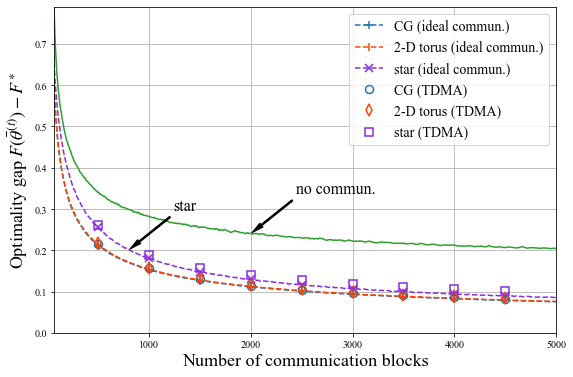

In [817]:
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))
df1.rolling(window = 20).mean().mean(axis = 1).plot(style = '--', marker = '+', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'CG (ideal commun.)')
df2.rolling(window = 20).mean().mean(axis = 1).plot(style = '--', color = 'orangered', marker = '|', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'2-D torus (ideal commun.)')
df3.rolling(window = 20).mean().mean(axis = 1).plot(style = '--', color = 'blueviolet', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'star (ideal commun.)')
df4.rolling(window = 29).mean().mean(axis = 1).plot(ls = '', color = 'C0', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'CG (TDMA)')
df5.rolling(window = 29).mean().mean(axis = 1).plot(ls = '', color = 'orangered', marker = 'd', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'2-D torus (TDMA)')
df6.rolling(window = 29).mean().mean(axis = 1).plot(ls = '', color = 'blueviolet', marker = 's', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'star (TDMA)')
# df7.rolling(window = 10).mean().mean(axis = 1).plot(color = 'saddlebrown', label = 'Ideal commun.')
df8.rolling(window = 49).mean().mean(axis = 1).plot(color = 'tab:green', label = '')
plt.xlabel(r'Number of communication blocks', fontsize = 18)
plt.ylabel(r'Optimality gap $F(\bar{\theta}^{(t)})-F^\ast$', fontsize = 18)
# plt.title(r'ER graph with $p = 0.2$ and $\barP = -57$dBm', fontsize = 14)
plt.xlim((70, 5000))
plt.ylim((0, 0.79))
plt.grid()

# Place legend for individual curves
plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'no commun.',
            xy = (2000, .24), xycoords = 'data',
            xytext = (45, 40), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 1.5, headwidth = 5, shrink = 0.03))
_ = ax.annotate(r'star',
            xy = (800, .20), xycoords = 'data',
            xytext = (45, 40), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 1.5, headwidth = 5, shrink = 0.03))
# _ = ax.annotate(r'CG',
#             xy = (2000, .13), xycoords = 'data',
#             xytext = (-60, -35), textcoords = 'offset points', fontsize = 16,
#             arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
# _ = ax.annotate(r'2-D torus',
#             xy = (2300, .13), xycoords = 'data',
#             xytext = (30, 25), textcoords = 'offset points', fontsize = 16,
#             arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# _ = plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/ana_og_vs_topology.eps',format='eps', dpi=600)
plt.show()

In [808]:
df8.rolling(window = 49).mean().mean(axis = 1)[70]

0.7863804098416367

In [2]:
net.__version__

'2.4'